In [2]:
import numpy as np
from scipy.sparse.linalg import *
from scipy.constants import *
from matplotlib import pyplot as plt
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
from AdaptiveParametricSpaceMapper import *
from QCircuit import *
%matplotlib inline

0.5*Uphix*(Uphix/4062500000 + 4*nphi1/13 + 4*nphi2/13) + 0.5*nphi1*(4*Uphix/13 + 18000000000*nphi1/13 - 8000000000*nphi2/13) + 0.5*nphi2*(4*Uphix/13 - 8000000000*nphi1/13 + 18000000000*nphi2/13) - 1000000000.0*cos(phi1) - 1000000000.0*cos(phi2) - 800000000.0*cos(phi1 + phi2 - phix) + 2800000000.0
[  2.24725563e+09 -1.25311390e-06j   2.29878442e+09 +4.65922535e-07j
   2.94337549e+09 -3.64175090e-07j   3.19998159e+09 +7.10680033e-07j]


/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


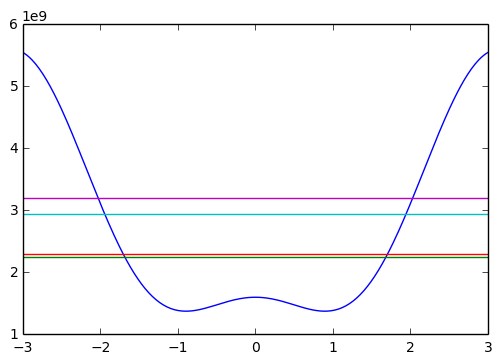

In [13]:
FQ3JJ = QCircuit()
FQ3JJ.add_element(QJosephsonJunction('JJ1'), ['GND', '1'])
FQ3JJ.add_element(QJosephsonJunction('JJ2'), ['1', '2'])
FQ3JJ.add_element(QJosephsonJunction('JJ3'), ['2', '3'])
FQ3JJ.add_element(QCapacitance('C1'), ['GND', '1'])
FQ3JJ.add_element(QCapacitance('C2'), ['1', '2'])
FQ3JJ.add_element(QCapacitance('C3'), ['2', '3'])
        
phi1 = QVariable('phi1')
phi2 = QVariable('phi2')
phix = QVariable('phix')
phi1.create_grid(32, 1)
phi2.create_grid(32, 1)
FQ3JJ.add_variable(phi1)
FQ3JJ.add_variable(phi2)
FQ3JJ.add_variable(phix)
FQ3JJ.map_nodes_linear(['GND', '1', '2', '3'], 
                       ['phi1', 'phi2', 'phix'], 
                       np.asarray([[0,0,0],[1,0,0],[1,1,0],[0,0,1]]))

EjEc_ratio_steps = 16
alpha_steps = 1
flux_steps = 16
energies = np.zeros((EjEc_ratio_steps,alpha_steps,flux_steps,2), dtype=np.complex128)
Ej = 1e9
Ec = 4*1e9
FQ3JJ.find_element('JJ1').set_critical_current(Ej)
FQ3JJ.find_element('JJ2').set_critical_current(Ej)
FQ3JJ.find_element('C1').set_capacitance(2/Ec)
FQ3JJ.find_element('C2').set_capacitance(2/Ec)
alpha = 0.8
FQ3JJ.find_element('JJ3').set_critical_current(Ej*alpha)
FQ3JJ.find_element('C3').set_capacitance(2*alpha/Ec)
phix.set_parameter(np.pi, 0)
print(FQ3JJ.symbolic_hamiltonian()) 
U = FQ3JJ.symbolic_hamiltonian(False)
calc = sympy.lambdify({"phi1","phi2","phix"},U,'numpy')

phi_steps = 256
phi_space = np.linspace(-3,3,phi_steps)

teta_steps = 256
teta_space = np.linspace(-3,3,teta_steps)

phi_grid, teta_grid = np.meshgrid(phi_space, teta_space)

calc_grid = calc(phi1 = teta_grid,phi2  = phi_grid, phix = np.pi)
FQ3JJ.calculate_potentials()
[eigenenergies,eigenfunctions] = FQ3JJ.diagonalize_phase(num_states = 4)
en = eigenenergies
print(en)
plt.plot(phi_space, calc(phi1 = phi_space, phi2 = phi_space, phix = np.pi))
for e in en:
    plt.plot(phi_space, e*np.ones_like(phi_space))

In [16]:
FQ3JJ = QCircuit()
FQ3JJ.add_element(QJosephsonJunction('JJ1'), ['GND', '1'])
FQ3JJ.add_element(QJosephsonJunction('JJ2'), ['1', '2'])
FQ3JJ.add_element(QJosephsonJunction('JJ3'), ['2', '3'])
FQ3JJ.add_element(QCapacitance('C1'), ['GND', '1'])
FQ3JJ.add_element(QCapacitance('C2'), ['1', '2'])
FQ3JJ.add_element(QCapacitance('C3'), ['2', '3'])
        
phi1 = QVariable('φ1')
phi2 = QVariable('φ2')
phix = QVariable('φx')
phi1.create_grid(32, 1)
phi2.create_grid(32, 1)
FQ3JJ.add_variable(phi1)
FQ3JJ.add_variable(phi2)
FQ3JJ.add_variable(phix)
FQ3JJ.map_nodes_linear(['GND', '1', '2', '3'], 
                       ['φ1', 'φ2', 'φx'], 
                       np.asarray([[0,0,0],[1,0,0],[1,1,0],[0,0,1]]))

def CalcSingleGap(parameters):
    Ej = 10**parameters[0]
    Ec = 2e9
    alpha = parameters[1]
    qubit_flux = parameters[2]
    FQ3JJ.find_element('JJ1').set_critical_current(Ej)
    FQ3JJ.find_element('JJ2').set_critical_current(Ej)
    FQ3JJ.find_element('C1').set_capacitance(2/Ec)
    FQ3JJ.find_element('C2').set_capacitance(2/Ec)
    FQ3JJ.find_element('JJ3').set_critical_current(Ej*alpha)
    FQ3JJ.find_element('C3').set_capacitance(2*alpha/Ec)   
    phix.set_parameter(qubit_flux, 0)
    FQ3JJ.calculate_potentials()
    [eigenenergies, eigenfunctions] = FQ3JJ.diagonalize_phase()
    print('Ej: {0:8.3g}, Ec: {1:8.3g}, alpha: {2:8.3g}, flux: {3:8.3g}. Gap: {4:8.3g}'.format(
            Ej, Ec, alpha, qubit_flux, np.abs(eigenenergies[1]-eigenenergies[0])))
    return eigenenergies

GapMapper = AdaptiveParametricSpaceMapper([('Ej', 9, 12), 
                                           ('alpha', 0.5, 1.0), 
                                           ('qubit_flux', 0, 2*np.pi)], 
                                            CalcSingleGap, 
                                            lambda x: np.log10(np.abs(x[:,1]-x[:,0])))

In [ ]:
GapMapper.run(max_vertices = 2000)

In [17]:
resGrid = np.asarray(np.meshgrid(np.linspace(9, 12, 50), np.linspace(0.5, 1.0, 50), np.linspace(np.pi, np.pi, 1)))
resGridLin = np.reshape(resGrid, (3,50*50)).T
dataLin = griddata(GapMapper.vertices, GapMapper.funvals, GapMapper.inverse_rescale_parameters_multiple(resGridLin))
#print(GapMapper.vertices.shape)
plt.pcolor(np.log10(np.reshape(dataLin[:,1]-dataLin[:,0], (50,50))))

ValueError: different number of values and points